In [55]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(reshape2)
library(ggsci)
library(rstatix)
library(ggpubr)
library(ggplot2) 
library(GGally) 
library(pheatmap)


In [71]:

is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  } else {return('black')}
}

In [72]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read composite score

In [73]:
df<-read.csv('/home//workspace/IHA_Figure_Revision/Figure1/04_CompositeScore/BRI_CompositeScore_Up.csv') %>% 
filter(sample.visitName=='Flu Year 1 Day 0')

In [74]:
celltype_order<-c("Core naive CD8 T cell","CM CD8 T cell","GZMK+ CD27+ EM CD8 T cell","Naive CD4 Treg",
                 "Core naive CD4 T cell","CM CD4 T cell","GZMB- CD27- EM CD4 T cell","GZMB- CD27+ EM CD4 T cell")
df$celltype<-factor(df$celltype,levels=celltype_order)

In [1]:
celltype_order_wrapped <- str_wrap(celltype_order, width = 12)


ERROR: Error in str_wrap(celltype_order, width = 16): could not find function "str_wrap"


# Plotting

In [76]:
df$`Age Group`<-df$`AgeGroup`

In [77]:
df$`Age Group`<-factor(df$`Age Group`,level=c('Young','Older'))

In [80]:
df$celltype <- gsub(" cell", '', df$celltype)
names(color_vector)<-str_wrap(names(color_vector), width = 12)
df$celltype_wrapped <- str_wrap(df$celltype, width = 12)
strip_colors <- setNames(
  color_vector[ unique(df$celltype_wrapped) ],
  unique(df$celltype_wrapped)
)

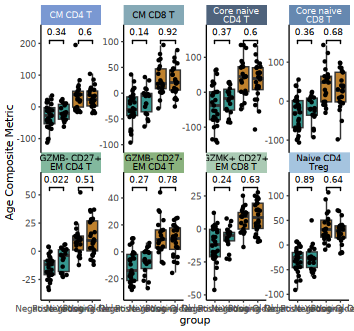

In [97]:
options(repr.plot.width = 70/25.4, repr.plot.height =  90/25.4)
df$group=paste0(df$CMV,'-',df$`Age Group`)
df$group=factor(df$group,levels=c("Negative-Young","Positive-Young","Negative-Older", "Positive-Older"))
my_comparisons <- list(c("Negative-Young", "Positive-Young"),c("Negative-Older", "Positive-Older"))
p <- ggplot(df  ,
              aes(x = group, y = composite_score_sum_scaled_mean)) +
    geom_boxplot( lwd=0.3, outlier.shape = NA,aes(fill = `Age Group`))+
    geom_point(aes(y = composite_score_sum_scaled_mean), 
               position = position_jitter(width = 0.2), color="black", size=1, stroke=0) +
    facet_wrap(~ celltype_wrapped, scales = 'free_y', ncol = 4)   +
stat_compare_means(
  comparisons = my_comparisons[1],
  label = "p.format",
  label.y.npc = "top",
  size = 1.75,
  vjust = -0.5
) +
stat_compare_means(
  comparisons = my_comparisons[2],
  label = "p.format",
  label.y.npc = "top",
  size = 1.75,
  vjust = -0.5
)+
    theme_classic(base_size = 6) +
    scale_fill_manual(values = c("Older" = '#bf812d', 
                                 "Young" = '#35978f')) +
    scale_y_continuous(limits = c(NA, NA), 
                       expand = expansion(mult = c(0.1, 0.15)))+
ylab('Age Composite Metric')+ 
theme(
  axis.line = element_line(colour = "black"),
  legend.position = "none",
  legend.title = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  strip.background = element_rect(linewidth = 0),
  axis.title.x = element_text(margin = margin(t = 2)),
  panel.spacing = unit(-0.1, "mm"),
  strip.text = element_text(margin = margin(b = 1, t = 1))
)

plot <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', plot$layout$name))

pal <- color_vector[celltype_order_wrapped]
text_color <- sapply(color_vector[celltype_order_wrapped], is_dark_color)

for (i in seq_along(strips)) {
  k <- which(grepl('rect', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- adjustcolor(pal[i], alpha.f = 0.8)
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}
options(repr.plot.width = 75/25.4, repr.plot.height =  70/25.4)

plot(plot)
ggsave('FigureH.pdf',plot,width = 75/25.4, height =  70/25.4)